<a href="https://colab.research.google.com/github/Anya-Gupta-05/Image_Dominat_Color_Prediciton/blob/main/CNN_Image_Dominant_Color.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import cv2
import os
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [2]:
from google.colab import files
uploaded=files.upload()

Saving archive (10).zip to archive (10).zip


In [1]:
import zipfile
import os

zip_path = "/content/archive (10).zip"  # Adjust if your zip file is named differently
extract_path = "/content/images"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete!")

Extraction complete!


In [2]:
import os
import cv2
import numpy as np

image_dir = '/content/images/seg_train/seg_train'  # Make sure this path is correct
images = []
labels = []

max_images_per_class = 1500  # Limit to 300 images per class

for class_name in os.listdir(image_dir):
    class_path = os.path.join(image_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
    image_files = image_files[:max_images_per_class]  # Take only the first 200

    for img_file in image_files:
        img_path = os.path.join(class_path, img_file)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Couldn't read: {img_path}")
            continue
        img = cv2.resize(img, (100, 100))
        images.append(img / 255.0)  # Normalize
        labels.append(class_name)


In [3]:
print(f"Total images loaded: {len(images)}")
print(f"Total labels loaded: {len(labels)}")
print(f"Unique classes: {set(labels)}")
print(f"Shape of one image: {images[0].shape}")



Total images loaded: 9000
Total labels loaded: 9000
Unique classes: {'street', 'mountain', 'glacier', 'forest', 'buildings', 'sea'}
Shape of one image: (100, 100, 3)


In [4]:
import pandas as pd
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# === Load CSV with dominant_rgb ===
csv_path = "/content/kmeans_output.csv"  # <-- Update this to your actual CSV filename
df = pd.read_csv(csv_path)

# === Helper: Convert RGB array string to color name ===
def rgb_to_color_name(rgb_str):
    try:
        rgb = list(map(int, rgb_str.strip('[]').split()))
        r, g, b = rgb
        if r >= g and r >= b:
            return 'Red'
        elif g >= r and g >= b:
            return 'Green'
        else:
            return 'Blue'
    except:
        return None  # Skip malformed entries

# === Build a mapping from filename to full image path using os.walk ===
image_dir = "/content/images/seg_train"
image_map = {}

valid_exts = ('.jpg', '.jpeg', '.png')
for root, _, files in os.walk(image_dir):
    for file in files:
        if file.lower().endswith(valid_exts):
            image_map[file] = os.path.join(root, file)

# === Load images and labels ===
images = []
labels = []

for idx, row in df.iterrows():
    filename = row['filename']
    label = rgb_to_color_name(row['dominant_rgb'])

    if label is None or filename not in image_map:
        print(f"Skipping: {filename}")
        continue

    img_path = image_map[filename]
    img = cv2.imread(img_path)

    if img is None:
        print(f"Couldn't read: {img_path}")
        continue

    try:
        img = cv2.resize(img, (100, 100))
    except Exception as e:
        print(f"Resize failed for {img_path}: {e}")
        continue

    images.append(img / 255.0)  # Normalize
    labels.append(label)

# === Final Stats ===
print(f"Loaded {len(images)} images and {len(labels)} labels.")

Loaded 10000 images and 10000 labels.


In [5]:
# === Convert to arrays and encode labels ===
X = np.array(images)
le = LabelEncoder()
y = to_categorical(le.fit_transform(labels))

# === Split the data ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Define simple CNN model ===
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(100,100,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')  # 3 classes: Red, Green, Blue
])
print(model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 33856)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,166,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,186,435 (8.34 MB)

 Trainable params: 2,186,435 (8.34 MB)

 Non-trainable params: 0 (0.00 B)

None


In [6]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# === Train the model ===
model.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test))



Epoch 1/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.7599 - loss: 0.6157 - val_accuracy: 0.8640 - val_loss: 0.3425
Epoch 2/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.8880 - loss: 0.2946 - val_accuracy: 0.8775 - val_loss: 0.2999
Epoch 3/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8902 - loss: 0.2806 - val_accuracy: 0.8875 - val_loss: 0.2770
Epoch 4/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9075 - loss: 0.2207 - val_accuracy: 0.8725 - val_loss: 0.3401
Epoch 5/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9366 - loss: 0.1685 - val_accuracy: 0.9065 - val_loss: 0.2471
Epoch 6/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9608 - loss: 0.1151 - val_accuracy: 0.9080 - val_loss: 0.2614
Epoch 7/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9709 - loss: 0.0857 - val_accuracy: 0.9255 - val_loss: 0.2195
Epoch 8/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9751 - loss: 0.0735 - val_ac

In [7]:
# === Evaluate ===
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.2f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9296 - loss: 0.2814
Test Accuracy: 0.93


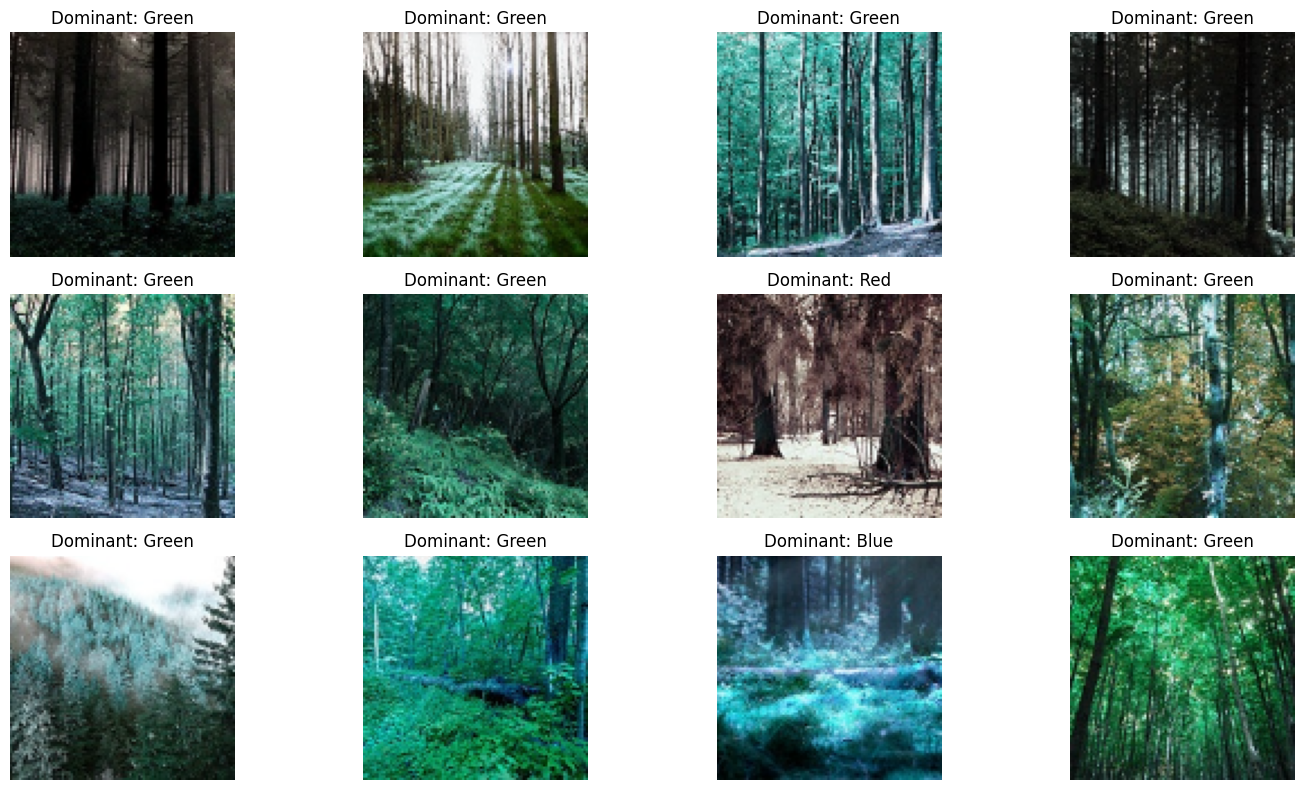

In [8]:
import matplotlib.pyplot as plt

# Number of samples to show
num_samples = 12  # You can change this

plt.figure(figsize=(15, 8))

for i in range(num_samples):
    plt.subplot(3, 4, i + 1)
    plt.imshow(images[i])
    plt.title(f"Dominant: {labels[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


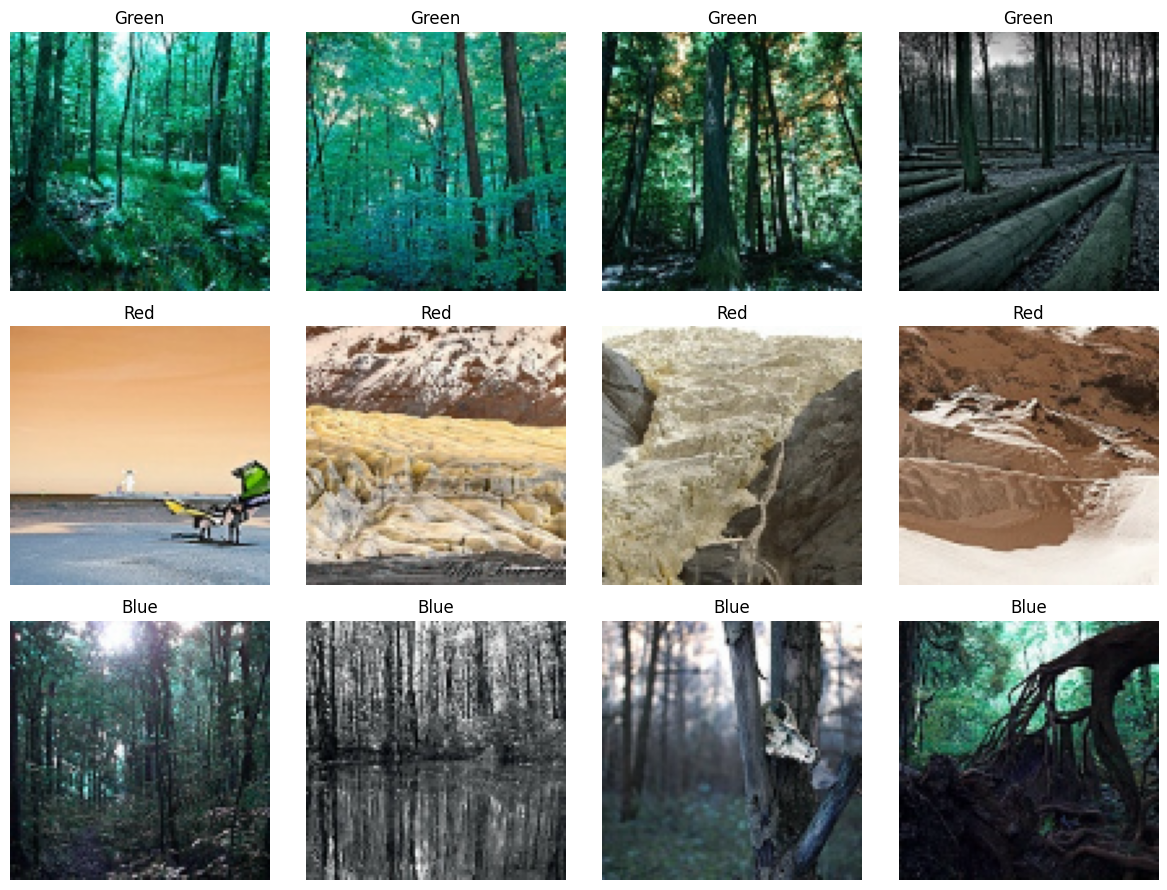

In [9]:
import matplotlib.pyplot as plt
from collections import defaultdict
import random

# Group images by dominant color
classwise_images = defaultdict(list)

for img, label in zip(images, labels):
    classwise_images[label].append(img)

# Show up to 4 samples from each class
samples_per_class = 4
classes = list(classwise_images.keys())
num_classes = len(classes)

plt.figure(figsize=(samples_per_class * 3, num_classes * 3))

for i, label in enumerate(classes):
    samples = random.sample(classwise_images[label], min(samples_per_class, len(classwise_images[label])))
    for j, img in enumerate(samples):
        plt.subplot(num_classes, samples_per_class, i * samples_per_class + j + 1)
        plt.imshow(img)
        plt.title(f"{label}")
        plt.axis('off')

plt.tight_layout()
plt.show()


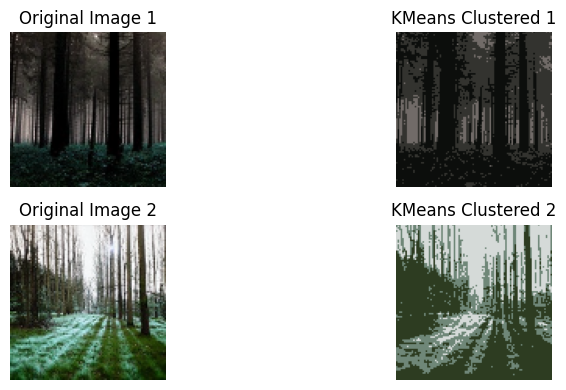

In [13]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import cv2

def show_kmeans_clusters(image, k=3):
    # Resize image for faster clustering
    small_img = cv2.resize(image, (100, 100))
    img_data = small_img.reshape((-1, 3))

    # Apply KMeans
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(img_data)
    clustered = kmeans.cluster_centers_[kmeans.labels_]
    clustered_img = clustered.reshape(small_img.shape).astype(np.uint8)

    return clustered_img

# Pick two sample images
img1 = images[0]  # Assuming these are loaded and normalized [0-1]
img2 = images[1]

# Convert back to [0-255] for OpenCV
img1_uint8 = (img1 * 255).astype(np.uint8)
img2_uint8 = (img2 * 255).astype(np.uint8)

# Get clustered images
clustered1 = show_kmeans_clusters(img1_uint8)
clustered2 = show_kmeans_clusters(img2_uint8)

# Show side by side
plt.figure(figsize=(10, 4))

for i, (orig, cluster) in enumerate([(img1_uint8, clustered1), (img2_uint8, clustered2)]):
    plt.subplot(2, 2, i*2 + 1)
    plt.imshow(orig)
    plt.title(f"Original Image {i+1}")
    plt.axis('off')

    plt.subplot(2, 2, i*2 + 2)
    plt.imshow(cluster)
    plt.title(f"KMeans Clustered {i+1}")
    plt.axis('off')


plt.tight_layout()
plt.show()

